In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LeakyReLU , BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


In [2]:
data  = pd.read_csv("/content/screentime_analysis.csv")

In [3]:
data.head()

,Date,App,Usage (minutes),Notifications,Times Opened
0,2024-08-07,Instagram,81,24,57
1,2024-08-08,Instagram,90,30,53
2,2024-08-26,Instagram,112,33,17
3,2024-08-22,Instagram,82,11,38
4,2024-08-12,Instagram,59,47,16


In [4]:
data_gan = data.drop(columns=['Date','App'])

In [5]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_gan)
normal_dataframe = pd.DataFrame(normalized_data,columns=data_gan.columns)

In [6]:
normal_dataframe.head()

,Usage (minutes),Notifications,Times Opened
0,0.677966,0.163265,0.571429
1,0.754237,0.204082,0.530612
2,0.940678,0.224490,0.163265
3,0.686441,0.074830,0.377551
4,0.491525,0.319728,0.153061


In [7]:
latent_dim = 100
latent_dim = 100

def build_generator(latent_dim):
  model = Sequential([
      Dense(128,input_dim=latent_dim),
      LeakyReLU(alpha=0.01),
      BatchNormalization(momentum=0.8),
      Dense(256),
      LeakyReLU(alpha=0.01),
      BatchNormalization(momentum=0.8),
      Dense(512),
      LeakyReLU(alpha=0.01),
      BatchNormalization(momentum=0.8),
      Dense(3,activation='sigmoid')

  ])
  return model


generator = build_generator(latent_dim)
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,659 (713.51 KB)

 Trainable params: 180,867 (706.51 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [8]:
noise = np.random.normal(0,1,(1000,latent_dim))

generated_data = generator.predict(noise)

generated_data[:5]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[0.5314608 , 0.5637712 , 0.6077019 ],
       [0.5411615 , 0.5419268 , 0.5522085 ],
       [0.5267657 , 0.61330956, 0.5290713 ],
       [0.51660436, 0.5311677 , 0.55147195],
       [0.5131066 , 0.5707958 , 0.51264995]], dtype=float32)

In [9]:
def build_discriminator():
  model = Sequential([
      Dense(512,input_shape=(3,)),
      LeakyReLU(alpha=0.01),
      Dense(256),
      LeakyReLU(alpha=0.01),
      Dense(128),
      LeakyReLU(alpha=0.01),
      Dense(1,activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
  return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,401 (650.00 KB)

 Trainable params: 166,401 (650.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def build_gans(generator,discriminator):
  discriminator.trainable = False
  model = Sequential([generator,discriminator])
  model.compile(loss='binary_crossentropy',optimizer=Adam())
  return model

gan = build_gans(generator,discriminator)
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 3)              │       182,659 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       166,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,060 (1.33 MB)

 Trainable params: 180,867 (706.51 KB)

 Non-trainable params: 168,193 (657.00 KB)

In [11]:
def train_gan(gan,generator,discriminator,data,epochs=1000,batch_size=128,latent_dim=100):
  for epoch in range(epochs):
    idx = np.random.randint(0,data.shape[0] , batch_size)
    real_data = data[idx]

    noise = np.random.normal(0,1,(batch_size,latent_dim))
    fake_data = generator.predict(noise)

    real_labels = np.ones((batch_size , 1 ))
    fake_labels = np.zeros((batch_size , 1 ))

    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_data , fake_labels)

    noise = np.random.normal(0,1,(batch_size,latent_dim))
    valid_labels = np.ones((batch_size , 1))

    g_loss = gan.train_on_batch(noise,valid_labels)

    if epoch % 100 == 0:
      print(f"Epoch {epoch} : D Loss : {0.5 * np.add(d_loss_real , d_loss_fake)} , G Loss : {g_loss}")

train_gan(gan , generator , discriminator , normalized_data , epochs = 1000 , batch_size=128 , latent_dim = latent_dim)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 : D Loss : [0.694136   0.26757812] , G Loss : 0.6980992555618286
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━

In [12]:
# generate new data
noise = np.random.normal(0, 1, (1000, latent_dim))  # generate 1000 synthetic samples
generated_data = generator.predict(noise)

# convert the generated data back to the original scale
generated_data_rescaled = scaler.inverse_transform(generated_data)

# convert to DataFrame
generated_df = pd.DataFrame(generated_data_rescaled, columns=data_gan.columns)

generated_df.head()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,Usage (minutes),Notifications,Times Opened
0,114.999763,49.383663,76.201080
1,105.183388,42.795990,62.663845
2,118.251961,48.863598,82.111198
3,4.345349,8.545928,9.306053
4,118.046814,52.100380,82.120819



🎯 HOW TO USE THIS IN COLAB:

1. First, make sure your screentime_analysis.csv is uploaded to Colab

2. Run this entire cell to load all classes and functions

3. Then run one of these options:

   OPTION A - Quick evaluation of your existing data:
   ```python
   # Replace with your actual data variables
   evaluator = evaluate_synthetic_data(
       real_data=your_real_data,
       synthetic_data=your_synthetic_data,
       feature_names=['Usage_Time', 'Notifications', 'Times_Opened']
   )
   ```
   
   OPTION B - Complete pipeline with improved GAN:
   ```python
   results = run_complete_pipeline()
   ```
   
   OPTION C - Manual step-by-step:
   ```python
   # Load and prepare your data
   data = pd.read_csv("/content/screentime_analysis.csv")
   data_features = data.drop(columns=['Date', 'App']).values
   feature_names = ['Usage_Time', 'Notifications', 'Times_Opened']  # Adjust as needed
   
   # Evaluate existing synthetic data
   evaluator = evaluate_synthetic_data(data_features

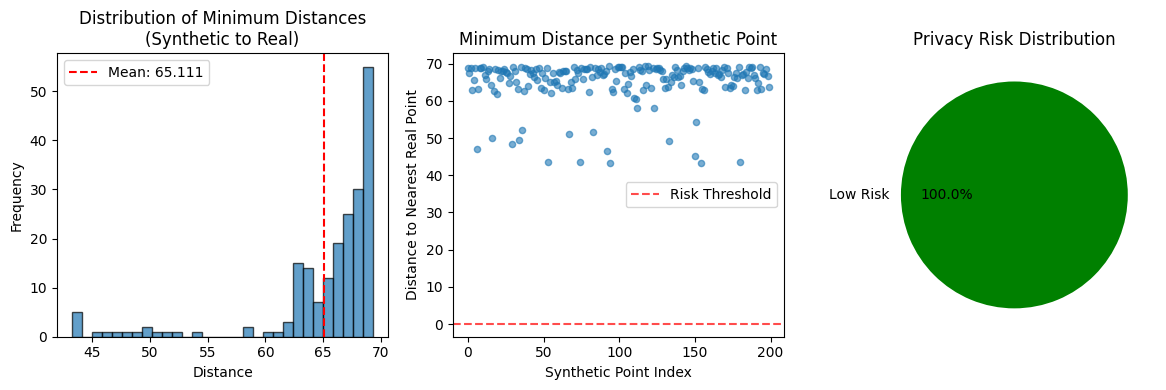

   Privacy Assessment Summary:
   Mean Minimum Distance: 65.1107
   Privacy Score: 65.1107
   High Risk Points: 0
📊 Creating Distribution Visualizations...


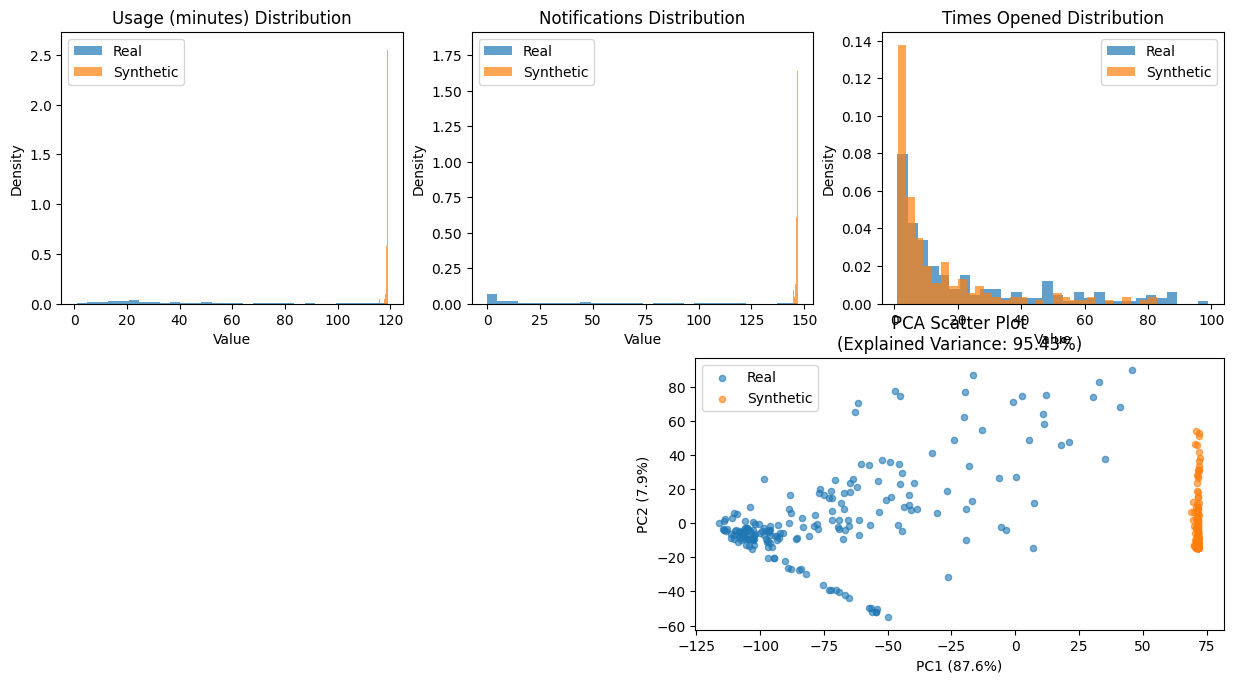


📋 COMPREHENSIVE SYNTHETIC DATA EVALUATION REPORT
📊 Statistical Quality Score: 0.344/1.000
🔗 Correlation Preservation Score: 0.460/1.000
🤖 ML Utility Score: 0.012/1.000
🔐 Privacy Score: 1.000/1.000

🏆 OVERALL QUALITY SCORE: 0.454/1.000
⚠️  FAIR: Synthetic data has some limitations.

6. Training Progress Analysis...


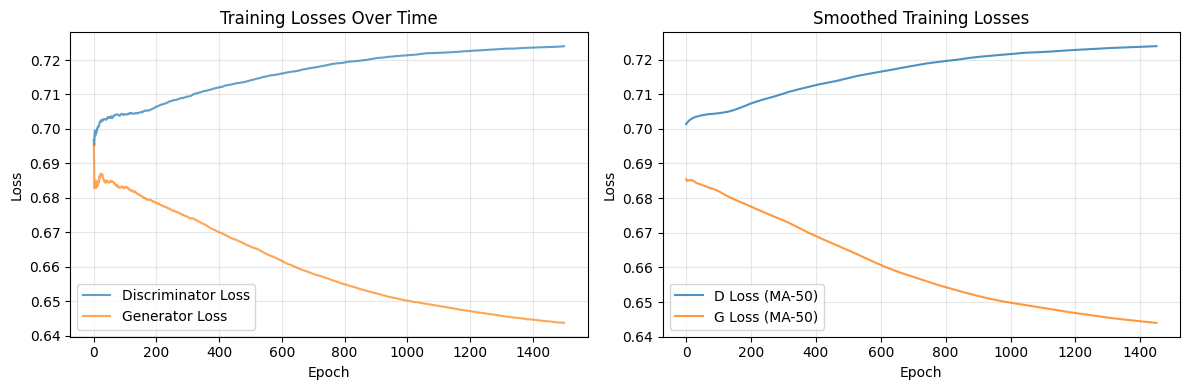

In [15]:
# -*- coding: utf-8 -*-
"""
Complete Colab Pipeline: Improved GAN Training + Comprehensive Evaluation
Run this in Google Colab after installing required packages
"""

# Install required packages (run this cell first in Colab)
"""
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy scipy
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# PART 1: SYNTHETIC DATA EVALUATOR CLASS
# ============================================================================

class SyntheticDataEvaluator:
    """
    Comprehensive evaluation suite for synthetic data quality, utility, and privacy
    """

    def __init__(self, real_data, synthetic_data, feature_names=None):
        self.real_data = np.array(real_data) if not isinstance(real_data, np.ndarray) else real_data
        self.synthetic_data = np.array(synthetic_data) if not isinstance(synthetic_data, np.ndarray) else synthetic_data

        if feature_names is None:
            self.feature_names = [f'Feature_{i}' for i in range(self.real_data.shape[1])]
        else:
            self.feature_names = feature_names

        self.n_features = self.real_data.shape[1]
        self.results = {}

    def statistical_metrics(self):
        print("🔍 Computing Statistical Metrics...")

        metrics = {
            'ks_test': [],
            'wasserstein_distance': [],
            'jensen_shannon_divergence': [],
            'mean_difference': [],
            'std_difference': []
        }

        for i in range(self.n_features):
            real_feature = self.real_data[:, i]
            synthetic_feature = self.synthetic_data[:, i]

            # Kolmogorov-Smirnov Test
            ks_stat, ks_p = stats.ks_2samp(real_feature, synthetic_feature)
            metrics['ks_test'].append({'statistic': ks_stat, 'p_value': ks_p})

            # Wasserstein Distance
            wasserstein_dist = stats.wasserstein_distance(real_feature, synthetic_feature)
            metrics['wasserstein_distance'].append(wasserstein_dist)

            # Jensen-Shannon Divergence
            js_div = self._jensen_shannon_divergence(real_feature, synthetic_feature)
            metrics['jensen_shannon_divergence'].append(js_div)

            # Mean and Standard Deviation differences
            mean_diff = abs(np.mean(real_feature) - np.mean(synthetic_feature))
            std_diff = abs(np.std(real_feature) - np.std(synthetic_feature))
            metrics['mean_difference'].append(mean_diff)
            metrics['std_difference'].append(std_diff)

        self.results['statistical_metrics'] = metrics
        self._print_statistical_summary()
        return metrics

    def _jensen_shannon_divergence(self, p, q, bins=50):
        p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
        q_hist, _ = np.histogram(q, bins=bin_edges, density=True)

        p_hist = p_hist / np.sum(p_hist)
        q_hist = q_hist / np.sum(q_hist)

        epsilon = 1e-10
        p_hist = p_hist + epsilon
        q_hist = q_hist + epsilon

        m = 0.5 * (p_hist + q_hist)
        js_div = 0.5 * stats.entropy(p_hist, m) + 0.5 * stats.entropy(q_hist, m)
        return js_div

    def correlation_preservation(self):
        print("🔗 Analyzing Correlation Preservation...")

        real_corr = np.corrcoef(self.real_data.T)
        synthetic_corr = np.corrcoef(self.synthetic_data.T)

        corr_diff = np.abs(real_corr - synthetic_corr)
        mean_corr_diff = np.mean(corr_diff[np.triu_indices_from(corr_diff, k=1)])
        max_corr_diff = np.max(corr_diff[np.triu_indices_from(corr_diff, k=1)])
        frobenius_norm = np.linalg.norm(corr_diff, 'fro')

        correlation_results = {
            'real_correlation_matrix': real_corr,
            'synthetic_correlation_matrix': synthetic_corr,
            'correlation_difference': corr_diff,
            'mean_correlation_difference': mean_corr_diff,
            'max_correlation_difference': max_corr_diff,
            'frobenius_norm': frobenius_norm
        }

        self.results['correlation_preservation'] = correlation_results
        print(f"   Mean Correlation Difference: {mean_corr_diff:.4f}")
        print(f"   Max Correlation Difference: {max_corr_diff:.4f}")

        return correlation_results

    def distribution_visualization(self, figsize=(15, 12)):
        print("📊 Creating Distribution Visualizations...")

        fig = plt.figure(figsize=figsize)

        n_cols = min(3, self.n_features)
        n_rows = (self.n_features + n_cols - 1) // n_cols

        for i in range(self.n_features):
            plt.subplot(n_rows + 2, n_cols, i + 1)
            plt.hist(self.real_data[:, i], bins=30, alpha=0.7, label='Real', density=True)
            plt.hist(self.synthetic_data[:, i], bins=30, alpha=0.7, label='Synthetic', density=True)
            plt.title(f'{self.feature_names[i]} Distribution')
            plt.legend()
            plt.xlabel('Value')
            plt.ylabel('Density')

        # PCA Scatter Plot
        if self.n_features > 1:
            plt.subplot(n_rows + 2, 2, 2 * (n_rows + 1))
            pca = PCA(n_components=2)

            combined_data = np.vstack([self.real_data, self.synthetic_data])
            pca_combined = pca.fit_transform(combined_data)

            real_pca = pca_combined[:len(self.real_data)]
            synthetic_pca = pca_combined[len(self.real_data):]

            plt.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.6, label='Real', s=20)
            plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], alpha=0.6, label='Synthetic', s=20)
            plt.title(f'PCA Scatter Plot\n(Explained Variance: {pca.explained_variance_ratio_.sum():.2%})')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
            plt.legend()

        plt.tight_layout()
        plt.show()

    def ml_utility_test(self, test_size=0.2, random_state=42):
        print("🤖 Running ML Utility Tests...")

        real_labels = np.zeros(len(self.real_data))
        synthetic_labels = np.ones(len(self.synthetic_data))

        combined_data = np.vstack([self.real_data, self.synthetic_data])
        combined_labels = np.hstack([real_labels, synthetic_labels])

        X_train_disc, X_test_disc, y_train_disc, y_test_disc = train_test_split(
            combined_data, combined_labels, test_size=test_size, random_state=random_state
        )

        feature_medians = np.median(self.real_data, axis=0)

        def create_classification_task(data):
            return (data[:, 0] > feature_medians[0]).astype(int)

        models = {
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'LogisticRegression': LogisticRegression(random_state=random_state, max_iter=1000)
        }

        results = {}

        for model_name, model in models.items():
            print(f"   Testing {model_name}...")
            model_results = {}

            try:
                # Discriminator test
                if len(np.unique(y_train_disc)) > 1:
                    model_disc = model.__class__(**model.get_params())
                    scaler = StandardScaler()
                    X_train_disc_scaled = scaler.fit_transform(X_train_disc)
                    X_test_disc_scaled = scaler.transform(X_test_disc)

                    model_disc.fit(X_train_disc_scaled, y_train_disc)
                    pred_disc = model_disc.predict(X_test_disc_scaled)
                    pred_disc_proba = model_disc.predict_proba(X_test_disc_scaled)[:, 1]

                    model_results['discriminator_accuracy'] = accuracy_score(y_test_disc, pred_disc)
                    model_results['discriminator_auc'] = roc_auc_score(y_test_disc, pred_disc_proba)
                else:
                    model_results['discriminator_accuracy'] = 0.5
                    model_results['discriminator_auc'] = 0.5

                # Utility tests
                X_train_real, X_test_real = train_test_split(
                    self.real_data, test_size=test_size, random_state=random_state
                )
                y_train_real_task = create_classification_task(X_train_real)
                y_test_real_task = create_classification_task(X_test_real)

                if len(np.unique(y_train_real_task)) > 1:
                    model_real = model.__class__(**model.get_params())
                    scaler_real = StandardScaler()
                    X_train_real_scaled = scaler_real.fit_transform(X_train_real)
                    X_test_real_scaled = scaler_real.transform(X_test_real)

                    model_real.fit(X_train_real_scaled, y_train_real_task)
                    pred_real = model_real.predict(X_test_real_scaled)
                    model_results['real_to_real_accuracy'] = accuracy_score(y_test_real_task, pred_real)
                else:
                    model_results['real_to_real_accuracy'] = 0.5

            except Exception as e:
                print(f"   Warning: Error in {model_name} testing: {str(e)}")
                model_results = {
                    'discriminator_accuracy': 0.5,
                    'discriminator_auc': 0.5,
                    'real_to_real_accuracy': 0.5
                }

            results[model_name] = model_results

        self.results['ml_utility'] = results
        self._print_ml_utility_summary(results)
        return results

    def privacy_assurance(self, k=5):
        print("🔐 Assessing Privacy Risks...")

        distances = cdist(self.synthetic_data, self.real_data, metric='euclidean')
        k_nearest_distances = np.sort(distances, axis=1)[:, :k]
        min_distances = k_nearest_distances[:, 0]

        privacy_results = {
            'min_distances': min_distances,
            'mean_min_distance': np.mean(min_distances),
            'std_min_distance': np.std(min_distances),
            'k_nearest_distances': k_nearest_distances,
            'distance_threshold_violations': np.sum(min_distances < 0.1),
            'privacy_score': np.mean(min_distances)
        }

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.hist(min_distances, bins=30, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Minimum Distances\n(Synthetic to Real)')
        plt.xlabel('Distance')
        plt.ylabel('Frequency')
        plt.axvline(np.mean(min_distances), color='red', linestyle='--',
                   label=f'Mean: {np.mean(min_distances):.3f}')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.scatter(range(len(min_distances)), min_distances, alpha=0.6, s=20)
        plt.title('Minimum Distance per Synthetic Point')
        plt.xlabel('Synthetic Point Index')
        plt.ylabel('Distance to Nearest Real Point')
        plt.axhline(0.1, color='red', linestyle='--', alpha=0.7, label='Risk Threshold')
        plt.legend()

        plt.subplot(1, 3, 3)
        risk_levels = ['Low Risk' if d > 0.2 else 'Medium Risk' if d > 0.1 else 'High Risk'
                      for d in min_distances]
        risk_counts = pd.Series(risk_levels).value_counts()
        colors = ['green', 'orange', 'red']
        plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
                colors=colors[:len(risk_counts)])
        plt.title('Privacy Risk Distribution')

        plt.tight_layout()
        plt.show()

        self.results['privacy_assurance'] = privacy_results
        self._print_privacy_summary(privacy_results)
        return privacy_results

    def comprehensive_report(self):
        print("\n" + "="*80)
        print("📋 COMPREHENSIVE SYNTHETIC DATA EVALUATION REPORT")
        print("="*80)

        if not self.results:
            print("❌ No evaluation results found. Please run evaluation methods first.")
            return

        scores = []

        # Statistical Quality Score
        if 'statistical_metrics' in self.results:
            metrics = self.results['statistical_metrics']
            ks_scores = [1 - m['statistic'] for m in metrics['ks_test']]
            ws_scores = [1 / (1 + d) for d in metrics['wasserstein_distance']]
            js_scores = [1 / (1 + d) for d in metrics['jensen_shannon_divergence']]
            statistical_score = np.mean(ks_scores + ws_scores + js_scores)
            print(f"📊 Statistical Quality Score: {statistical_score:.3f}/1.000")
            scores.append(statistical_score)

        # Correlation Preservation Score
        if 'correlation_preservation' in self.results:
            corr_score = 1 - self.results['correlation_preservation']['mean_correlation_difference']
            print(f"🔗 Correlation Preservation Score: {corr_score:.3f}/1.000")
            scores.append(corr_score)

        # ML Utility Score
        if 'ml_utility' in self.results:
            ml_results = self.results['ml_utility']
            avg_disc_acc = np.mean([ml_results[model]['discriminator_accuracy']
                                   for model in ml_results])
            utility_score = 1 - abs(avg_disc_acc - 0.5) * 2
            print(f"🤖 ML Utility Score: {utility_score:.3f}/1.000")
            scores.append(utility_score)

        # Privacy Score
        if 'privacy_assurance' in self.results:
            privacy_score = min(1.0, self.results['privacy_assurance']['privacy_score'] * 2)
            print(f"🔐 Privacy Score: {privacy_score:.3f}/1.000")
            scores.append(privacy_score)

        # Overall Score
        if scores:
            overall_score = np.mean(scores)
            print(f"\n🏆 OVERALL QUALITY SCORE: {overall_score:.3f}/1.000")

            if overall_score >= 0.8:
                print("✅ EXCELLENT: Synthetic data is of high quality!")
            elif overall_score >= 0.6:
                print("✅ GOOD: Synthetic data is acceptable for most use cases.")
            elif overall_score >= 0.4:
                print("⚠️  FAIR: Synthetic data has some limitations.")
            else:
                print("❌ POOR: Synthetic data needs significant improvement.")

        print("="*80)

    def _print_statistical_summary(self):
        metrics = self.results['statistical_metrics']
        print("   Statistical Metrics Summary:")
        print(f"   Mean KS Statistic: {np.mean([m['statistic'] for m in metrics['ks_test']]):.4f}")
        print(f"   Mean Wasserstein Distance: {np.mean(metrics['wasserstein_distance']):.4f}")
        print(f"   Mean JS Divergence: {np.mean(metrics['jensen_shannon_divergence']):.4f}")

    def _print_ml_utility_summary(self, results):
        print("   ML Utility Summary:")
        for model_name in results:
            print(f"   {model_name}:")
            print(f"     Discriminator Accuracy: {results[model_name]['discriminator_accuracy']:.3f}")
            print(f"     Discriminator AUC: {results[model_name]['discriminator_auc']:.3f}")

    def _print_privacy_summary(self, privacy_results):
        print("   Privacy Assessment Summary:")
        print(f"   Mean Minimum Distance: {privacy_results['mean_min_distance']:.4f}")
        print(f"   Privacy Score: {privacy_results['privacy_score']:.4f}")
        print(f"   High Risk Points: {privacy_results['distance_threshold_violations']}")

# ============================================================================
# PART 2: IMPROVED GAN CLASS
# ============================================================================

class ImprovedGAN:
    def __init__(self, input_dim, latent_dim=128):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.generator = None
        self.discriminator = None
        self.gan = None

    def build_improved_generator(self):
        model = Sequential([
            Dense(256, input_dim=self.latent_dim),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dropout(0.3),

            Dense(512),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dropout(0.3),

            Dense(256),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dropout(0.3),

            Dense(128),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),

            Dense(self.input_dim, activation='tanh')
        ])

        self.generator = model
        return model

    def build_improved_discriminator(self):
        model = Sequential([
            Dense(128, input_shape=(self.input_dim,)),
            LeakyReLU(alpha=0.2),
            Dropout(0.4),

            Dense(256),
            LeakyReLU(alpha=0.2),
            Dropout(0.4),

            Dense(128),
            LeakyReLU(alpha=0.2),
            Dropout(0.4),

            Dense(64),
            LeakyReLU(alpha=0.2),
            Dropout(0.4),

            Dense(1, activation='sigmoid')
        ])

        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.0001, beta_1=0.5),
            metrics=['accuracy']
        )

        self.discriminator = model
        return model

    def build_improved_gan(self):
        self.discriminator.trainable = False

        model = Sequential([
            self.generator,
            self.discriminator
        ])

        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
        )

        self.gan = model
        return model

    def train_improved_gan(self, data, epochs=2000, batch_size=64, sample_interval=200):
        print("🚀 Starting Improved GAN Training...")

        # Convert data to proper range for tanh activation
        data_tanh = 2 * data - 1  # Convert [0,1] to [-1,1] for tanh

        d_losses = []
        g_losses = []

        for epoch in range(epochs):
            # Train Discriminator
            idx = np.random.randint(0, data_tanh.shape[0], batch_size)
            real_data = data_tanh[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            fake_data = self.generator.predict(noise, verbose=0)

            # Label smoothing
            real_labels = np.ones((batch_size, 1)) * 0.9
            fake_labels = np.zeros((batch_size, 1)) + 0.1

            d_loss_real = self.discriminator.train_on_batch(real_data, real_labels)
            d_loss_fake = self.discriminator.train_on_batch(fake_data, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator (multiple times)
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                valid_labels = np.ones((batch_size, 1))
                g_loss = self.gan.train_on_batch(noise, valid_labels)

            d_losses.append(d_loss[0])
            g_losses.append(g_loss)

            if epoch % sample_interval == 0:
                print(f"Epoch {epoch:6d} | D Loss: {d_loss[0]:.4f} | D Acc: {d_loss[1]:.2%} | G Loss: {g_loss:.4f}")

        return d_losses, g_losses

    def generate_improved_data(self, n_samples):
        noise = np.random.normal(0, 1, (n_samples, self.latent_dim))
        generated_data = self.generator.predict(noise, verbose=0)

        # Convert back from tanh range [-1,1] to [0,1]
        generated_data = (generated_data + 1) / 2
        generated_data = np.clip(generated_data, 0, 1)

        return generated_data

# ============================================================================
# PART 3: CONVENIENCE FUNCTION
# ============================================================================

def evaluate_synthetic_data(real_data, synthetic_data, feature_names=None):
    """
    Convenience function to run complete evaluation
    """
    evaluator = SyntheticDataEvaluator(real_data, synthetic_data, feature_names)

    # Run all evaluations
    evaluator.statistical_metrics()
    evaluator.correlation_preservation()
    evaluator.ml_utility_test()
    evaluator.privacy_assurance()

    # Create visualizations
    evaluator.distribution_visualization()

    # Generate comprehensive report
    evaluator.comprehensive_report()

    return evaluator

# ============================================================================
# PART 4: COMPLETE PIPELINE FOR YOUR DATA
# ============================================================================

def run_complete_pipeline():
    """
    Complete pipeline for your screentime data in Colab
    """
    print("🚀 RUNNING COMPLETE PIPELINE FOR SCREENTIME DATA")
    print("="*60)

    # Step 1: Load your data (modify path as needed)
    print("1. Loading data...")
    try:
        data = pd.read_csv("/content/screentime_analysis.csv")
        print(f"   Data loaded successfully: {data.shape}")
        print(f"   Columns: {list(data.columns)}")
    except FileNotFoundError:
        print("   ❌ Data file not found. Please upload screentime_analysis.csv to Colab")
        return

    # Step 2: Prepare data
    print("\n2. Preparing data...")
    data_features = data.drop(columns=['Date', 'App']).values
    feature_names = [col for col in data.columns if col not in ['Date', 'App']]

    # Normalize data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data_features)

    print(f"   Features: {feature_names}")
    print(f"   Data shape: {normalized_data.shape}")

    # Step 3: Train improved GAN
    print("\n3. Training Improved GAN...")
    improved_gan = ImprovedGAN(input_dim=normalized_data.shape[1], latent_dim=128)

    generator = improved_gan.build_improved_generator()
    discriminator = improved_gan.build_improved_discriminator()
    combined_gan = improved_gan.build_improved_gan()

    # Train the GAN
    d_losses, g_losses = improved_gan.train_improved_gan(
        normalized_data,
        epochs=1500,  # Reduced for Colab
        batch_size=32,
        sample_interval=150
    )

    # Step 4: Generate synthetic data
    print("\n4. Generating synthetic data...")
    n_synthetic = len(normalized_data)
    synthetic_normalized = improved_gan.generate_improved_data(n_synthetic)

    # Convert back to original scale
    synthetic_data = scaler.inverse_transform(synthetic_normalized)

    # Step 5: Evaluate both original and improved
    print("\n5. Evaluating Original GAN vs Improved GAN...")

    # You'll need your original synthetic data for comparison
    # Replace 'your_original_synthetic_data' with your actual variable
    print("\n📊 EVALUATING IMPROVED GAN:")
    evaluator_improved = evaluate_synthetic_data(
        real_data=data_features,
        synthetic_data=synthetic_data,
        feature_names=feature_names
    )

    # Step 6: Show training progress
    print("\n6. Training Progress Analysis...")
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
    plt.plot(g_losses, label='Generator Loss', alpha=0.7)
    plt.title('Training Losses Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    window = 50
    if len(d_losses) > window:
        d_ma = np.convolve(d_losses, np.ones(window)/window, mode='valid')
        g_ma = np.convolve(g_losses, np.ones(window)/window, mode='valid')
        plt.plot(d_ma, label=f'D Loss (MA-{window})', alpha=0.8)
        plt.plot(g_ma, label=f'G Loss (MA-{window})', alpha=0.8)
        plt.title('Smoothed Training Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'real_data': data_features,
        'improved_synthetic_data': synthetic_data,
        'evaluator': evaluator_improved,
        'improved_gan': improved_gan,
        'scaler': scaler
    }

# ============================================================================
# USAGE INSTRUCTIONS FOR COLAB
# ============================================================================

print("""
🎯 HOW TO USE THIS IN COLAB:

1. First, make sure your screentime_analysis.csv is uploaded to Colab

2. Run this entire cell to load all classes and functions

3. Then run one of these options:

   OPTION A - Quick evaluation of your existing data:
   ```python
   # Replace with your actual data variables
   evaluator = evaluate_synthetic_data(
       real_data=your_real_data,
       synthetic_data=your_synthetic_data,
       feature_names=['Usage_Time', 'Notifications', 'Times_Opened']
   )
   ```

   OPTION B - Complete pipeline with improved GAN:
   ```python
   results = run_complete_pipeline()
   ```

   OPTION C - Manual step-by-step:
   ```python
   # Load and prepare your data
   data = pd.read_csv("/content/screentime_analysis.csv")
   data_features = data.drop(columns=['Date', 'App']).values
   feature_names = ['Usage_Time', 'Notifications', 'Times_Opened']  # Adjust as needed

   # Evaluate existing synthetic data
   evaluator = evaluate_synthetic_data(data_features, your_synthetic_data, feature_names)
   ```

📁 Make sure your CSV file has the right path in Colab!
""")

# If you want to run the complete pipeline immediately, uncomment the next line:
results = run_complete_pipeline()